In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpmath
import time as t

from scipy.signal import firwin, lfilter, freqz, filtfilt

from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
# Spherical Bessel function
def SB(bws, n, t):
    
    if n == 0 and t == 0:
        return 1
    elif n > 0 and t == 0:
        return 0
    else:
        return np.real(np.sign(bws * t) * np.emath.sqrt((2 * n + 1) / (2 * bws * t)) * mpmath.besselj(n+0.5, bws * np.pi * t)) 

In [5]:
# Function to remove samples based on an external mask
def RemoveSamples(sig_arr, time_arr, percentage, eligible_mask, seed=31):
    """
    Removes samples from the signal and time arrays based on a given probability,
    but only from samples specified by an external mask.

    Parameters:
        sig_arr (np.array): Array of signal values.
        time_arr (np.array): Corresponding time values.
        percentage (float): Fraction of masked samples to remove (0 to 1).
        eligible_mask (np.array): Boolean mask indicating samples eligible for removal.
        seed (int): Random seed for reproducibility.

    Returns:
        np.array: Filtered signal values.
        np.array: Filtered time values.
    """

    if len(sig_arr) != len(time_arr) or len(sig_arr) != len(eligible_mask):
        raise ValueError("sig_arr, time_arr, and eligible_mask must have the same length.")

    if not (0 <= percentage <= 1):
        raise ValueError("percentage must be between 0 and 1.")

    # Indices where removal is allowed
    eligible_indices = np.where(eligible_mask)[0]
    n_eligible = len(eligible_indices)

    if n_eligible == 0:
        raise ValueError("No samples are eligible for removal.")

    n_remove = int(np.round(percentage * n_eligible))

    if n_remove > n_eligible:
        raise ValueError(
            f"Cannot remove {n_remove} samples; only {n_eligible} samples are eligible."
        )

    np.random.seed(seed)

    # Randomly choose which eligible samples to remove
    remove_indices = np.random.choice(
        eligible_indices, size=n_remove, replace=False
    )

    # Final mask: start with all True, then remove selected indices
    final_mask = np.ones(len(sig_arr), dtype=bool)
    final_mask[remove_indices] = False

    return sig_arr[final_mask], time_arr[final_mask]

In [6]:
# Function to get samples at specific timestamps
def get_samples_at_timestamps(time_array, signal_array, target_timestamps):

    time_array = np.array(time_array)
    signal_array = np.array(signal_array)
    
    # Find the indices where the time matches the target timestamps
    indices = np.where(np.isin(time_array, target_timestamps))[0]
    
    # Return the signal values at those indices
    return signal_array[indices]

In [7]:
num_t =501
DEG = 100
legendre_B = np.zeros((DEG+1, num_t))
bws = 0.2

for i in range(num_t):
    for deg in range(DEG+1):
        legendre_B[deg, i] =SB(bws, deg, i-num_t//2)

In [8]:
def reconstruct_signal_using_windows(full_signal,full_time, full_range_array, window_size, recon_size, overlap_size):
    global num_t
    '''    
    This code reconstructs a given signal at range_array time_intervals 
    from a non uniformly sampled signal by combining multiple windows. 
    '''
    
    regula = 14.5
    mu = 10 ** -regula  # regularization factor for least squares
    unit_time = 1
    DEG = 100
    
    app_signal_windows = []
    app_time_windows = []
    
    pos = full_time[0]
    start_index = 0
    start_index_range = 0
    step_size = window_size - overlap_size
    
    total_duration = full_time[-1] - full_time[0]  # Calculate the total time duration of the signal
    step_size = (window_size - overlap_size)  # Calculate step size based on window size and overlap
    number_of_windows = int(total_duration / (step_size * unit_time))  # Find the number of windows
    
    window = 0
    
    print("number of windows is", number_of_windows)
    total_time =0
    while pos + window_size*unit_time <= full_time[-1]:
        
        window+=1
        
        start_time = t.time()
        
        ##Getting the window to reconstruct
        end_index = start_index
        while full_time[end_index] <= pos + window_size*unit_time :
            
            end_index+=1
        if start_index == end_index:
            end_index = len(full_signal)
            
        start_index_range = 0
        while full_range_array[start_index_range] <= pos + (window_size//2-recon_size//2)*unit_time :
            start_index_range +=1
            
        signal= full_signal[start_index:end_index]
        time = full_time[start_index:end_index]
        
        #Centering the time around zero
        sub = time[len(time)//2]
        time = time - sub
        
        #Getting the time window to reconstruct
        new_start_index = start_index
        while full_time[new_start_index] <= pos + step_size*unit_time :
            new_start_index+=1
        start_index = new_start_index-1
    
        lh = len(signal)
        
        #Input matrix
        A = np.zeros((lh, DEG + 1))
        for k in range(DEG + 1):
            for j in range(lh):
                A[j, k] = legendre_B[k, time[j]+int(num_t//2)]

        #LSF
        CDs = np.linalg.solve(np.dot(A.T, A) + mu * np.eye(DEG + 1), np.dot(A.T, signal))

        
        
        range_array = []
        

        #Getting the next startpoint for the window
        next_time = start_index_range
    
        while full_range_array[next_time]<= (pos + (window_size//2+recon_size//2 )*unit_time) :
            next_time+=1

        ##Getting the window to reconstruct
        range_array = full_range_array[start_index_range: next_time]
        original_range_array = range_array
        range_array = range_array - sub
        original_range_array = original_range_array[(range_array>time[0]) & (range_array<time[-1])]
        range_array = range_array[(range_array>time[0]) & (range_array<time[-1])] ##To remove points outside the known range
        
        ##Calculating reconstruction matrix
        N = len(range_array)//2
        if (len(range_array)%2):
            B = np.zeros((DEG + 1, 2 * N+1 ))
        else: 
            B = np.zeros((DEG + 1, 2 * N ))
        for k in range(DEG + 1):
            for j in range(-N, N+1):
                if (j==N and len(range_array)%2==0):
                    break
                B[k, N + j] = legendre_B[k, range_array[N+j] +int(num_t//2)]

        app = np.dot(CDs, B) ##Calculating the approximation
        app = app.reshape(-1,1)
        app_signal_windows.append(app.reshape(1, -1))
        app_time_windows.append(original_range_array.reshape(1, -1))
        
        pos = pos + step_size*unit_time
        end_time = t.time()
        total_time+= (end_time-start_time)
        print("amount of time for window", window,"is", end_time-start_time)
        print("average gap is", np.mean(np.diff(time*bws)))
        
    print("number of windows is :",len(app_signal_windows))
    print("total time taken is", total_time)
    return app_signal_windows, app_time_windows

In [9]:
def concatenate_signals_with_overlap(signals, times):
    """
    Concatenates multiple signal windows with corresponding time points, averaging overlap areas.
    
    Parameters:
    - signals: List of arrays of shape (1, d), each array representing a signal window.
    - times: List of arrays, each array representing the corresponding time points for each signal.
    
    Returns:
    - concatenated_signal: Array of the final concatenated signal with overlap averaging.
    - final_times: Array of the corresponding times for the concatenated signal.
    """
    
    concatenated_signal = np.array([])  # Store the concatenated signal
    final_times = np.array([])          # Store the corresponding time values
    

    
    for i, signal in enumerate(signals):
        signal = signal.flatten()  # Convert shape (1, d) to (d,)
        current_times = times[i]   # Corresponding time points for the current signal
        current_times = current_times.flatten() 
        count=0
        if i == 0:
            # Initialize with the first signal and its time points
            concatenated_signal = signal
            final_times = current_times
        else:
            # Find overlapping time points with the previous signal
            previous_times = final_times
            common_times = np.intersect1d(previous_times, current_times)
            
            if len(common_times) > 0:
                count+=1
                # Get indices of overlapping times in both previous and current signals
                prev_indices = np.searchsorted(previous_times, common_times)
                curr_indices = np.searchsorted(current_times, common_times)
                
                # Average the overlapping signal values
                concatenated_signal[prev_indices] = (
                    concatenated_signal[prev_indices] + signal[curr_indices]
                ) / 2
                
                # Append non-overlapping parts of the current signal
                non_overlap_indices = np.where(current_times > previous_times[-1])[0]
                if len(non_overlap_indices) > 0:
                    concatenated_signal = np.concatenate([concatenated_signal, signal[non_overlap_indices]])
                    final_times = np.concatenate([final_times, current_times[non_overlap_indices]])
            else:
                # No overlap, concatenate directly
                concatenated_signal = np.concatenate((concatenated_signal, signal))
                final_times = np.concatenate((final_times, current_times))
    print(count)
    return concatenated_signal, final_times

In [10]:
def calculate_metrics(real, approx, method_name):
    rmse = np.sqrt(np.mean((real - approx) ** 2))
    mae = np.mean(np.abs(real - approx))
    ss_total = np.sum((real - np.mean(real)) ** 2)
    ss_residual = np.sum((real - approx) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    print(f"{method_name} RMSE:", rmse)
    print(f"{method_name} MAE:", mae)
    print(f"{method_name} R²:", r_squared)

# **Reading Data**

In [11]:
df = pd.read_csv(r'Insert Path to Dataset', sep=r'\s+', header=None, names=['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage'], na_values='')

In [12]:
# Replace missing values (empty cells) with NaN
df.fillna(value=np.nan, inplace=True)

# Specify the time value you want to search for
specified_time = '08:11:56.681052'

# Find and print the row(s) with the specified time
matched_rows = df.loc[df['time'] == specified_time]

# Print the result
matched_rows

df.head()

,date,time,epoch,moteid,temperature,humidity,light,voltage
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


In [13]:
# Count the number of rows with at least one NaN value
rows_with_nans = df.isna().any(axis=1).sum()

# Print the result
print(f"Number of rows with NaN values: {rows_with_nans}")

Number of rows with NaN values: 93879


In [14]:
# Convert 'date' and 'time' columns to datetime objects for proper sorting
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'],errors='coerce')

# Sort the DataFrame by the 'datetime' column
df_sorted = df.sort_values(by='datetime')
df_sorted.drop(columns=['datetime'], inplace=True)

mote_1 = df_sorted.loc[df['moteid'] == 31]
epoch_df = mote_1
epoch_df_sorted = epoch_df.sort_values(by='epoch')

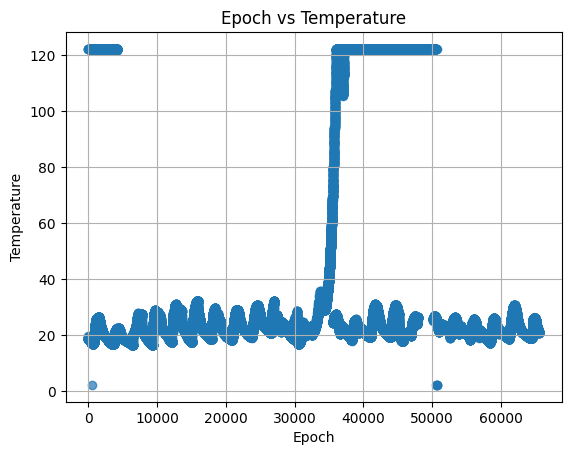

In [15]:
# Plot epoch vs temperature
plt.figure()
plt.scatter(epoch_df_sorted['epoch'], epoch_df_sorted['temperature'], alpha=0.7)
plt.title('Epoch vs Temperature')
plt.xlabel('Epoch')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

In [16]:
# Specify the start and end dates for the range
start_date = '2004-02-29'  # Example start date in 'yyyy-mm-dd' format
end_date = '2004-03-09'    # Example end date in 'yyyy-mm-dd' format

filtered_df = epoch_df_sorted[(epoch_df_sorted['date'] >= start_date) & (epoch_df_sorted['date'] <= end_date)]
filtered_df.shape

(22412, 8)

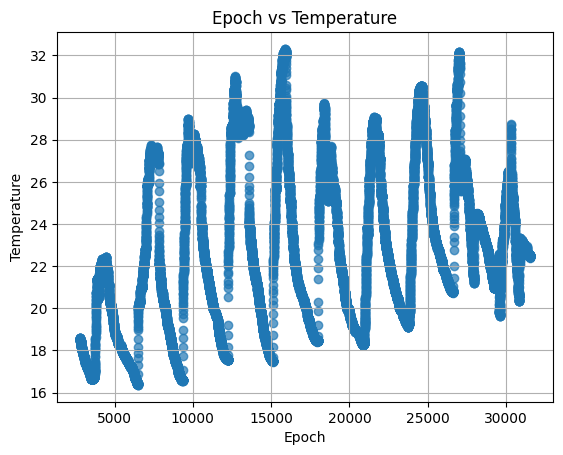

In [17]:
filtered_df = filtered_df.dropna()

# Plot epoch vs temperature
plt.figure()
plt.scatter(filtered_df['epoch'], filtered_df['temperature'], alpha=0.7)
plt.title('Epoch vs Temperature')
plt.xlabel('Epoch')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

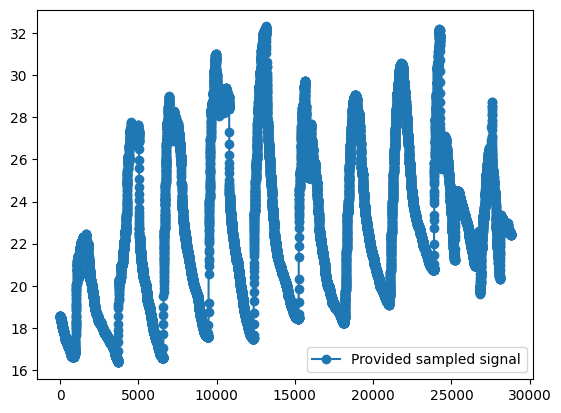

In [18]:
df_temp = filtered_df.drop(columns=['time', 'humidity', 'date', 'moteid', 'voltage', 'light'])
df_temp['epoch'] = df_temp['epoch'] - df_temp['epoch'].iloc[0]

plt.figure()
plt.plot(df_temp['epoch'], df_temp['temperature'], '-o', label='Provided sampled signal')
plt.legend()
plt.show()

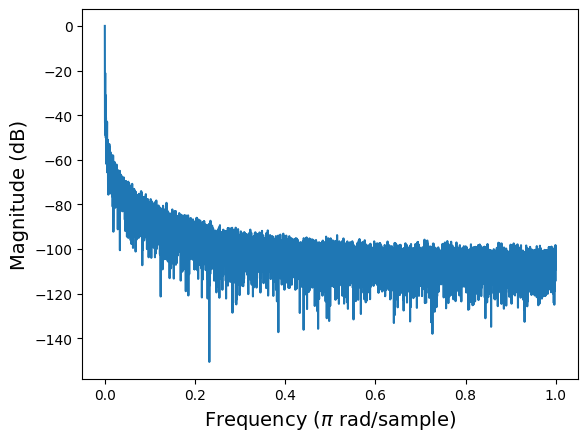

In [19]:
temperature_array = df_temp['temperature'].to_numpy()
Time = df_temp['epoch'].to_numpy()

temperature_array = temperature_array[::]
Time = Time[::]

signal = temperature_array
# Compute the DFT using NumPy's FFT
dft = np.fft.fft(signal)

# Compute the frequency axis
freqs = np.fft.fftfreq(len(signal))  # d = sampling interval

# Plot the magnitude spectrum
plt.plot(2*freqs[:len(freqs)//2], 20*np.log10((np.abs(dft[:len(dft)//2])/np.max(np.abs(dft[:len(dft)//2])))))  # Only plot positive frequencies
plt.xlabel("Frequency ($\\pi$ rad/sample)", fontsize=14)
plt.ylabel("Magnitude (dB)", fontsize=14)
# plt.title("DFT Magnitude Spectrum")

plt.savefig("dft_magnitude_spectrum.eps", format='eps', dpi=300, bbox_inches='tight')  # Save as EPS
plt.show()

# **Defining Parameters**

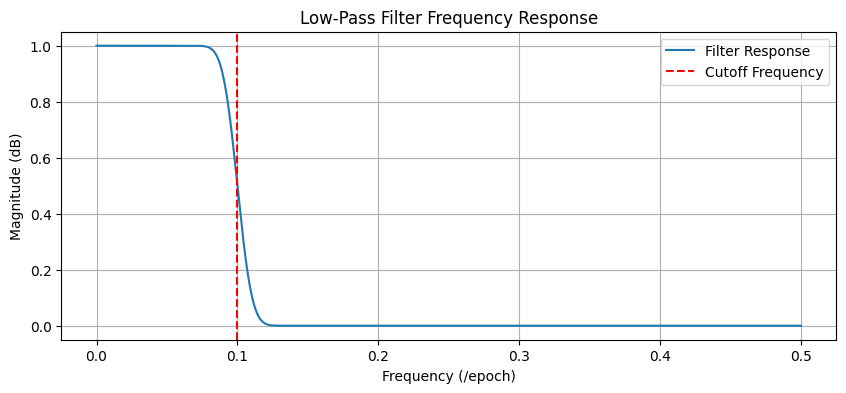

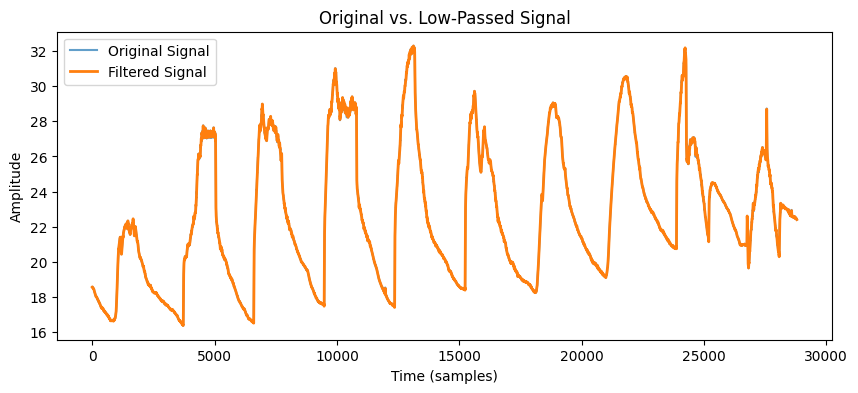

In [20]:
# Define filter parameters
signal = temperature_array

uniform_time = np.arange(Time[0], Time[-1] + 1, 1)
interp_func = interp1d(Time, signal, kind='linear')
uniform_signal = interp_func(uniform_time)

eligible_mask = np.isin(uniform_time, Time)

fs = 1  # Sampling frequency (normalized)
cutoff_freq = bws/2  # Cutoff frequency in Hz
num_taps = 301  # Filter order (increase for sharper cutoff)
stopband_atten = 60  # Desired stop-band attenuation in dB

# Design the FIR low-pass filter using the window method
fir_coeffs = firwin(num_taps, cutoff_freq, window=('kaiser', stopband_atten), fs=fs)

# Apply the filter to the signal
filtered_signal = filtfilt(fir_coeffs, 1.0, uniform_signal)

# Plot frequency response
w, h = freqz(fir_coeffs, worN=8000, fs=fs)
plt.figure(figsize=(10, 4))
plt.plot(w, (np.abs(h)), label="Filter Response")
plt.axvline(cutoff_freq, color='red', linestyle='--', label="Cutoff Frequency")
plt.xlabel("Frequency (/epoch)")
plt.ylabel("Magnitude (dB)")
plt.title("Low-Pass Filter Frequency Response")
plt.legend()
plt.grid()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4))
plt.plot(Time, signal, label="Original Signal", alpha=0.7)
plt.plot(filtered_signal, label="Filtered Signal", linewidth=2)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Original vs. Low-Passed Signal")
plt.legend()
plt.show()

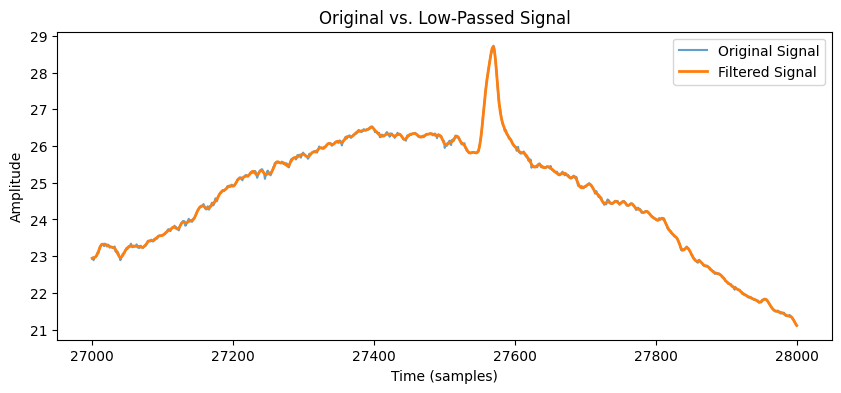

In [21]:
start = 27000
end = 28000
plt.figure(figsize=(10, 4))
plt.plot(Time[(Time<end) & (Time>start)], signal[(Time<end) & (Time>start)], label="Original Signal", alpha=0.7)
plt.plot(np.arange(start, end), filtered_signal[start:end], label="Filtered Signal", linewidth=2)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Original vs. Low-Passed Signal")
plt.legend()
plt.show()

In [22]:
print("RMSE is", np.mean((uniform_signal- filtered_signal)**2))
print("MAE is", np.mean(abs(uniform_signal- filtered_signal)))
print(max(abs(uniform_signal- filtered_signal)))
print(1- len(Time)/len(uniform_time), "is missing")

RMSE is 0.00023394921098961592
MAE is 0.009059488458805118
0.24347758606376857
0.2218055555555556 is missing


# **Removing Samples**

In [23]:
nyint = 1
ori_temperature_array = uniform_signal
temperature_array = filtered_signal
Time = uniform_time

In [24]:
skip_length = 10/bws
remove_size = 1*nyint/bws
randomizer = 31 #start time

remove_percentage = 0.6
percentage_from_eligible = (len(Time)*remove_percentage)/eligible_mask.sum()
print("percentage from eligible is", percentage_from_eligible)
temp_arr, time = RemoveSamples(temperature_array, Time, percentage_from_eligible, eligible_mask)

percentage from eligible is 0.7710155273960378


# **Signal Reconstruction**

In [25]:
##Window size and parameter size in terms of nyquist interval
window_size = 50/bws
recon_size = 0.25*window_size
overlap_size = 0.8*window_size
signal = temp_arr 

range_array = Time[:]
app_signal_windows, app_time_windows = reconstruct_signal_using_windows(signal,time,  range_array, window_size, recon_size, overlap_size)

number of windows is 575
amount of time for window 1 is 0.05656027793884277
average gap is 0.45045045045045057
amount of time for window 2 is 0.00799417495727539
average gap is 0.43620689655172423
amount of time for window 3 is 0.01057291030883789
average gap is 0.40983606557377056
amount of time for window 4 is 0.00800013542175293
average gap is 0.40819672131147544
amount of time for window 5 is 0.005826711654663086
average gap is 0.4078125
amount of time for window 6 is 0.0
average gap is 0.3744360902255639
amount of time for window 7 is 0.022176027297973633
average gap is 0.38015267175572515
amount of time for window 8 is 0.0069997310638427734
average gap is 0.38153846153846155
amount of time for window 9 is 0.008620977401733398
average gap is 0.41833333333333333
amount of time for window 10 is 0.0005898475646972656
average gap is 0.43103448275862066
amount of time for window 11 is 0.011078596115112305
average gap is 0.43478260869565216
amount of time for window 12 is 0.0
average ga

In [26]:
app_signal, app_time = concatenate_signals_with_overlap(app_signal_windows, app_time_windows)##Combining all the windows

1


In [27]:
differences = np.diff(bws*time)
print("mean time difference is", np.mean(differences),"times the Nyquist interval")
print(np.max(differences) ,"times the Nyquist interval is the maximum difference")
nyquist_interval = 1
# Compute percentages
greater_than_1x = np.mean(differences > nyquist_interval) * 100
greater_than_2x = np.mean(differences > 2 * nyquist_interval) * 100

# Print results
print(f"Percentage of readings > 1x Nyquist interval: {greater_than_1x:.2f}%")
print(f"Percentage of readings > 2x Nyquist interval: {greater_than_2x:.2f}%")

mean time difference is 0.49997395607257583 times the Nyquist interval
4.399999999999636 times the Nyquist interval is the maximum difference
Percentage of readings > 1x Nyquist interval: 8.30%
Percentage of readings > 2x Nyquist interval: 0.83%


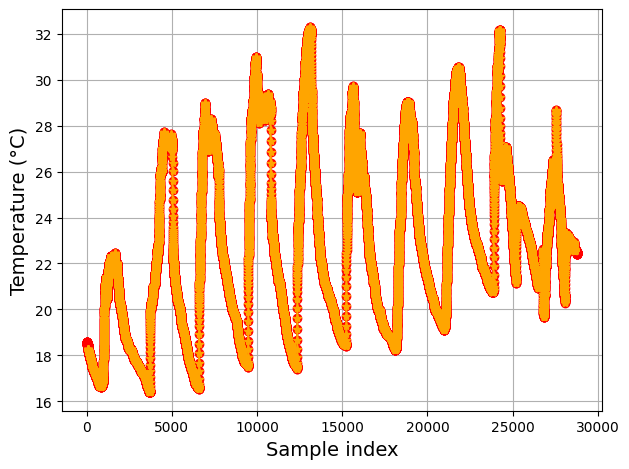

In [ ]:
plt.plot(Time[:], temperature_array[:],  '-o',label='Original Data Stream', color='red')
plt.plot(app_time.flatten(), app_signal,  '-*',label='Reconstructed Data Stream', color='orange')

plt.xlabel('Sample index', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)

plt.grid(True)
# plt.savefig("intel_reconstruct.pdf", format='pdf')
plt.tight_layout()
plt.show()

# **Measuring Performance**

In [29]:
def get_samples_at_timestamps(time_array, signal_array, target_timestamps):
    
    time_array = np.array(time_array)
    signal_array = np.array(signal_array)
    
    # Find the indices where the time matches the target timestamps
    indices = np.where(np.isin(time_array, target_timestamps))[0]
    
    # Return the signal values at those indices
    return signal_array[indices]

def elements_in_one_not_in_another(arr1, arr2):
    # Use numpy's setdiff1d to find elements in arr1 that are not in arr2
    return np.setdiff1d(arr1, arr2)

In [30]:
missing_time_stamps  = elements_in_one_not_in_another(Time, time)

missing_time_stamps = missing_time_stamps[(missing_time_stamps>=app_time[0]) & (missing_time_stamps<=app_time[-1])]

real_arr = get_samples_at_timestamps(Time,temperature_array, missing_time_stamps)
app_arr =  get_samples_at_timestamps(app_time, app_signal, missing_time_stamps)

calculate_metrics(real_arr, app_arr, "CDs")

errors = []
errors.append(abs(real_arr - app_arr))

CDs RMSE: 0.0009253164196666888
CDs MAE: 6.105943743654249e-05
CDs R²: 0.9999999437759155


# **Classical Methods**

In [31]:
# Perform linear interpolation
x_non_uniform = time
y_non_uniform = signal
start_time = t.time()
linear_interpolator = interp1d(x_non_uniform, y_non_uniform, kind='linear', fill_value="extrapolate")

# Get the interpolated values for the uniform grid
y_linear = linear_interpolator(app_time)
end_time = t.time()
print('Time taken:', end_time - start_time)
app_arr = get_samples_at_timestamps(app_time, y_linear, missing_time_stamps)

calculate_metrics(real_arr, app_arr, "Linear")
print((len(real_arr)/len(range_array))*100,"are missing")

errors.append(abs(real_arr- app_arr))

Time taken: 0.0033130645751953125
Linear RMSE: 0.01685978810841047
Linear MAE: 0.006635335854582044
Linear R²: 0.9999813342227412
59.52430555555556 are missing


In [36]:
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator

In [33]:
# Perform spline interpolation
start_time = t.time()
spline_interpolator = interp1d(x_non_uniform, y_non_uniform, kind='cubic', fill_value="extrapolate")
y_spline = spline_interpolator(app_time)
end_time = t.time()
print('Time taken:', end_time - start_time)

Time taken: 0.31470608711242676


In [34]:
# Perform nearest-neighbor interpolation
start_time = t.time()
nn_interpolator = interp1d(x_non_uniform, y_non_uniform, kind='nearest', fill_value=np.nan, bounds_error=False)
y_nn = nn_interpolator(app_time)
end_time = t.time()
print('Time taken:', end_time - start_time)

Time taken: 0.002153158187866211


In [35]:
# Get the interpolated values for the uniform grid and apply to missing timestamps
app_arr_spline = get_samples_at_timestamps(app_time, y_spline, missing_time_stamps)
app_arr_nn = get_samples_at_timestamps(app_time, y_nn, missing_time_stamps)

# Calculate and print RMSE for spline interpolation
calculate_metrics(real_arr, app_arr_spline, "Spline")
calculate_metrics(real_arr, app_arr_nn, "NN")

# Calculate and print the percentage of missing data
missing_percentage = (len(real_arr) / len(range_array)) * 100
print("Percentage of data missing:", missing_percentage, "%")

Spline RMSE: 0.009386510443942024
Spline MAE: 0.0025570456492490356
Spline R²: 0.9999942143762118
NN RMSE: 0.050640996892506084
NN MAE: 0.019502628437024102
NN R²: 0.9998315983480334
Percentage of data missing: 59.52430555555556 %


In [37]:
# Perform hermite interpolation
start_time = t.time()
hermite_interpolator = PchipInterpolator(x_non_uniform, y_non_uniform)
y_hermite = hermite_interpolator(app_time)
end_time = t.time()
print('Time taken:', end_time - start_time)
app_arr_hermite = get_samples_at_timestamps(app_time, y_hermite, missing_time_stamps)
calculate_metrics(real_arr, app_arr_hermite, "Hermite")

Time taken: 0.062477827072143555
Hermite RMSE: 0.011177978727577654
Hermite MAE: 0.004283956360302704
Hermite R²: 0.9999917951921955
